# Feature Engineering 
## Making a classifier on non-textual features. 

In [13]:
import pandas as pd
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from textblob import TextBlob
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot

In [2]:
data = pd.read_csv(r"E:\Yelp\Unfiltered Data\YelpZip\Customs\checkpoint")
data.head()

,index,user,item,review,rating,real,date
0,0,5044,0,drink be bad the hot chocolate be water down a...,1.0,-1,2014-11-16
1,1,5045,0,this be the bad experience ive ever have a cas...,1.0,-1,2014-09-08
2,2,5046,0,this be locate on the site of the old spruce s...,3.0,-1,2013-10-06
3,3,5047,0,i enjoy coffee and breakfast twice at toast du...,5.0,-1,2014-11-30
4,4,5048,0,i love toast the food choice be fantastic i lo...,5.0,-1,2014-08-28


In [ ]:
#Word Count
data['word_count'] = data['review'].progress_apply(lambda st: len(str(st).split()))
data.head()

In [ ]:
#Sentimental Deviation
pos_words = pd.read_table(r"C:\Users\elonm\Desktop\Yelp-Dataset-Analysis-master\poswords.txt", header=None)
neg_words = pd.read_table(r"C:\Users\elonm\Desktop\Yelp-Dataset-Analysis-master\negwords.txt", header=None)

def sentimental_deviation(txt):
    dev = 0
    flag = 0
    for word in txt.split():
        for pos in pos_words[0]:
            if pos == word.lower():
                if flag == -1:
                    dev = dev+1
                flag = 1
                #print(word, dev, flag)
        for neg in neg_words[0]:
            if neg == word.lower():
                if flag == 1:
                    dev = dev+1
                flag = -1
                #print(word, dev, flag)
    return dev

data['deviation'] = data['review'].progress_apply(lambda txt: sentimental_deviation(str((txt))))
data.head()

In [ ]:
#Save Checkpoint
data.to_csv(r"E:\Yelp\Unfiltered Data\YelpZip\Customs\feature_engg", header=True, index=False)

In [ ]:
#Sentiment Polarity
data['polarity'] = data['review'].progress_apply(lambda txt: TextBlob(str(txt)).sentiment.polarity)
data.head()

In [ ]:
#Count of sentimental words
sentimental_words = pos_words.append(neg_words)

def count_sentiment(sentence):
    sentence = str(sentence)
    count = 0
    for word in sentence.split():
        for sent_word in sentimental_words[0]:
            if sent_word in word:
                count += 1
    return count

data['count_sentiment'] = data['review'].progress_apply(lambda txt: count_sentiment(txt))

In [ ]:
#Save Checkpoint
data.to_csv(r"E:\Yelp\Unfiltered Data\YelpZip\Customs\feature_engg", header=True, index=False)

In [ ]:
#Positive Negative word count
def count_sentiment_pos(sentence):
    count = 0
    for word in sentence.split():
        for sent_word in pos_words[0]:
            if sent_word in word:
                count += 1
    return count

def count_sentiment_neg(sentence):
    count = 0
    for word in sentence.split():
        for sent_word in neg_words[0]:
            if sent_word in word:
                count += 1
    return count

data['pos_word_count'] = data['review'].progress_apply(lambda txt: count_sentiment_pos(str(txt)))
data['neg_word_count'] = data['review'].progress_apply(lambda txt: count_sentiment_neg(str(txt)))
data.head()

In [5]:
#Save Checkpoint
#data.to_csv(r"E:\Yelp\Unfiltered Data\YelpZip\Customs\feature_engg", header=True, index=False)
#Load
data = pd.read_csv(r"E:\Yelp\Unfiltered Data\YelpZip\Customs\feature_engg")
data.head()

,index,user,item,review,rating,real,date,word_count,deviation,polarity,count_sentiment,pos_word_count,neg_word_count
0,0,5044,0,drink be bad the hot chocolate be water down a...,1.0,-1,2014-11-16,36,2,-0.349259,7,1,6
1,1,5045,0,this be the bad experience ive ever have a cas...,1.0,-1,2014-09-08,247,6,0.023701,30,10,20
2,2,5046,0,this be locate on the site of the old spruce s...,3.0,-1,2013-10-06,50,2,0.296481,7,5,2
3,3,5047,0,i enjoy coffee and breakfast twice at toast du...,5.0,-1,2014-11-30,233,7,0.323958,49,35,14
4,4,5048,0,i love toast the food choice be fantastic i lo...,5.0,-1,2014-08-28,148,0,0.177201,22,19,3


In [6]:
def binarize(x):
    if x == -1:
        return 1
    else:
        return 0

data['real'] = data['real'].progress_apply(lambda x: binarize(x))

In [7]:
#Train on SVM and XGBRegressor
X = data[['item', 'rating', 'word_count', 'deviation', 'polarity', 'count_sentiment', 'pos_word_count', 'neg_word_count']]
X_train, X_test, y_train, y_test = train_test_split(X, data['real'], test_size=0.2, random_state=42)

In [ ]:
#SVM
svm_clf = svm.SVC(kernel='sigmoid', gamma='auto', verbose=True)
svm_clf.fit(X_train, y_train)  

In [9]:
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.87      1.00      0.93    105656
          1       0.00      0.00      0.00     16036

avg / total       0.75      0.87      0.81    121692



In [19]:
#XGB
xgb_model = XGBClassifier(learning_rate = 0.2, objective= 'binary:logistic')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
y_pred = xgb_model.predict(X_test)
y_pred = [round(value) for value in y_pred]
print(classification_report(y_test, y_pred))

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

          0       0.87      1.00      0.93    105656
          1       0.73      0.00      0.01     16036

avg / total       0.85      0.87      0.81    121692



[0.393586   0.1516035  0.12536444 0.05393586 0.12244898 0.04227405
 0.06851312 0.04227405]


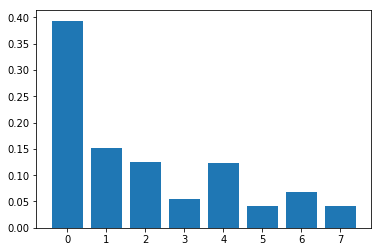

In [21]:
print(xgb_model.feature_importances_)
# plot
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()